<a href="https://colab.research.google.com/github/maloyan/HW_keras/blob/master/hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import albumentations as A

In [0]:
#DON'T FORGET TO CHANGE Runtime->GPU

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.metrics import RootMeanSquaredError, AUC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Lambda, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import backend as K

import os
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import random

import gc


from sklearn.neighbors import KNeighborsClassifier

gc.enable()

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
!nvidia-smi

Fri Jun 12 22:10:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
%%capture
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip;
!unzip ChestXRay2017.zip;
!cd ./chest_xray && mkdir val && cd val && mkdir NORMAL && mkdir PNEUMONIA;

In [0]:
TRAIN_SIZE = len(os.listdir('./chest_xray/train/NORMAL')) + len(os.listdir('./chest_xray/train/PNEUMONIA'))
for i in os.listdir('./chest_xray/train/NORMAL')[:(TRAIN_SIZE // 10)]:
    os.system(f'mv ./chest_xray/train/NORMAL/{i} ./chest_xray/val/NORMAL/{i}')

for i in os.listdir('./chest_xray/train/PNEUMONIA')[:(TRAIN_SIZE // 10)]:
    os.system(f'mv ./chest_xray/train/PNEUMONIA/{i} ./chest_xray/val/PNEUMONIA/{i}')

In [0]:
IMG_WIDTH, IMG_HEIGHT = 224, 224

TRAIN_DIR = './chest_xray/train/'
TEST_DIR = './chest_xray/test/'
VAL_DIR = './chest_xray/val/'

#TRAIN_VAL_SPLIT = 0.8
EPOCHS = 3
BATCH = 32

#TRAIN_SAMPLES = TRAIN_SIZE * TRAIN_VAL_SPLIT
#VAL_SAMPLES = TRAIN_SIZE * (1 - TRAIN_VAL_SPLIT)

#TRAIN_STEPS = TRAIN_SAMPLES // BATCH
#VAL_STEPS = VAL_SAMPLES // BATCH

TRAIN_SIZE = len(os.listdir('./chest_xray/train/NORMAL')) + len(os.listdir('./chest_xray/train/PNEUMONIA'))
VAL_SIZE = len(os.listdir('./chest_xray/val/NORMAL')) + len(os.listdir('./chest_xray/val/PNEUMONIA'))

TRAIN_STEPS = TRAIN_SIZE // BATCH
VAL_STEPS = VAL_SIZE // BATCH


if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (1, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)

#INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT)

In [0]:
doc_aug = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.RandomBrightness(p=0.8, limit=0.4),
    #A.RandomContrast(p=0.8, limit=0.4),
    #A.Blur(blur_limit=2),
    #A.ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.6, rotate_limit=45, p=0.8)
], p=1)

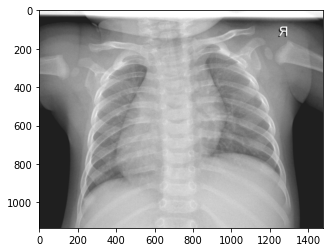

In [60]:
plt.imshow(doc_aug(image=img_normal, mask=None, bboxes=[], category_id=[])['image'])

NORMAL


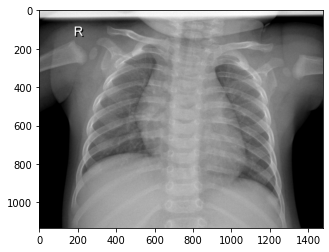

In [48]:
img_normal = cv2.imread('./chest_xray/train/NORMAL/' + os.listdir('./chest_xray/train/NORMAL')[0])

print('NORMAL')
plt.imshow(img_normal)
plt.show()

PNEUMONIA


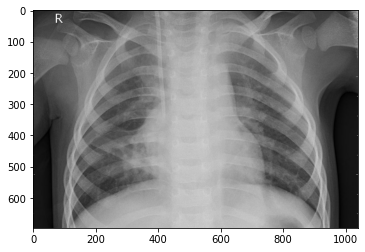

In [49]:
img_pneumonia = cv2.imread('./chest_xray/train/PNEUMONIA/' + os.listdir('./chest_xray/train/PNEUMONIA/')[0])

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

In [0]:
def loadimgs(path):
    X = []
    y = []

    for ind, i in enumerate(['NORMAL', 'PNEUMONIA']):
        for file_path in os.listdir(path + '/' + i):
            if file_path[-5:] == '.jpeg':
                img = cv2.imread(path + '/' + i + '/' + file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
                img = img.reshape(224, 224, 1)
                img = img.astype('float32')
                img /= 225
                
                X.append(img)
                y.append(ind)

    return np.stack(X), np.stack(y)

In [0]:
X_train, y_train = loadimgs('./chest_xray/train')
X_test, y_test = loadimgs('./chest_xray/test')
X_val, y_val = loadimgs('./chest_xray/val')

In [0]:
# Строим модель
# Она состоит из трех блоков вида: Свертка->Активация->MaxPooling

# После мы получаем признаки, которые запишем в одномерный массив с помощью Flatten
# Полносвязный слой выход 64->
# Активация Relu->
# 50% Дропаут ->
# Полносвязный слой с одним выходом->
# Нормализация с помощью Sigmoid

def base_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))

    return model

def classic_model(input_shape):
    
    model = base_model(input_shape)

    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

def siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = base_model(input_shape)

    model.add(Activation('sigmoid'))

    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([encoded_l, encoded_r])

    #prediction = Dense(1,activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[left_input,right_input],outputs=distance)
    
    return model, siamese_net

def siamese_triplet_model(input_shape, triplet_margin=.3):

    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    embedding_model = base_model(input_shape)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, siamese_triplet

In [0]:
def fit_nearest_neighbor(img_encoding, img_class, n_neighbors, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier

In [0]:
#CLASSIC

In [0]:
model = classic_model(INPUT_SHAPE)
    
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=['accuracy', AUC()]
)

In [14]:
model.fit(
    x = X_train,
    y = y_train,
    batch_size=BATCH,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

model.evaluate(X_test, y_test)

Epoch 1/3
131/131 [==============================] - 6s 48ms/step - loss: 0.3619 - accuracy: 0.8479 - auc: 0.8386 - val_loss: 0.4522 - val_accuracy: 0.8211 - val_auc: 0.9553
Epoch 2/3
131/131 [==============================] - 5s 42ms/step - loss: 0.1741 - accuracy: 0.9245 - auc: 0.9715 - val_loss: 0.2720 - val_accuracy: 0.9072 - val_auc: 0.9745
Epoch 3/3
20/20 [==============================] - 0s 22ms/step - loss: 0.6955 - accuracy: 0.7901 - auc: 0.9040


[0.6954589486122131, 0.7900640964508057, 0.904026985168457]

In [0]:
model = classic_model(INPUT_SHAPE)
    
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    optimizer=optimizers.Adam(),
    metrics=['accuracy', AUC()]
)

In [16]:
model.fit(
    x = X_train,
    y = y_train,
    batch_size=BATCH,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

model.evaluate(X_test, y_test)

Epoch 1/3
131/131 [==============================] - 6s 44ms/step - loss: 0.4493 - accuracy: 0.8364 - auc_1: 0.8390 - val_loss: 0.4324 - val_accuracy: 0.9014 - val_auc_1: 0.9818
Epoch 2/3
131/131 [==============================] - 5s 42ms/step - loss: 0.3346 - accuracy: 0.9260 - auc_1: 0.9741 - val_loss: 0.3713 - val_accuracy: 0.9244 - val_auc_1: 0.9852
Epoch 3/3
20/20 [==============================] - 0s 16ms/step - loss: 0.5436 - accuracy: 0.7756 - auc_1: 0.9321


[0.5436157584190369, 0.7756410241127014, 0.9321278929710388]

In [17]:
#contrastive_loss

gc.collect()

3607

In [0]:
num_classes = 2

def create_pairs(x, y):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            
            dn = (d + 1) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
# create training+test positive and negative pairs
tr_pairs, tr_y = create_pairs(X_train, y_train)
vl_pairs, vl_y = create_pairs(X_val, y_val)
te_pairs, te_y = create_pairs(X_test, y_test)

In [0]:
embedding, model = siamese_model(INPUT_SHAPE)
model.compile(
    loss=contrastive_loss, 
    optimizer=optimizers.Adam(), 
    #metrics=[accuracy]
)

In [22]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_data=([vl_pairs[:, 0], vl_pairs[:, 1]], vl_y))

Epoch 1/3
104/104 [==============================] - 11s 102ms/step - loss: 0.1428 - val_loss: 0.1495
Epoch 2/3
104/104 [==============================] - 10s 99ms/step - loss: 0.0597 - val_loss: 0.0637
Epoch 3/3
104/104 [==============================] - 10s 93ms/step - loss: 0.0364 - val_loss: 0.0640


In [0]:
train_embeds = embedding.predict(X_train)

In [0]:
classifier = fit_nearest_neighbor(train_embeds, y_train, 2)


In [0]:
e = embedding.predict(X_test)
op = classifier.predict(e)

In [26]:
(np.where(y_test == op))[0].shape[0] / y_test.shape[0]

0.7740384615384616

In [27]:
#Triplet v2
gc.collect()

17073

In [0]:
def generate_triplets(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in range(2):
    pos_indices = np.argwhere(label == i)[:,0]
    neg_indices = np.argwhere(label != i)[:,0]

    # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_pos = pos_indices[choice_pos]

    choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
    choice_neg = neg_indices[choice_neg]

    sub_x_anc = dataset[choice_anchor]
    
    sub_x_pos = dataset[choice_pos]

    sub_x_neg = dataset[choice_neg]
      
        
    if(x is None):
      x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
      y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
    else:
      x[0] = np.vstack((x[0], (sub_x_anc)))
      x[1] = np.vstack((x[1], (sub_x_pos)))
      x[2] = np.vstack((x[2], (sub_x_neg)))

      y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
  return x, y

def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)


In [0]:
train_x, train_y = generate_triplets(X_train, y_train, 500)
val_x, val_y = generate_triplets(X_val, y_val, 100)
test_x, test_y = generate_triplets(X_test, y_test, 100)

In [0]:
embedding_model, siamese_triplet = siamese_triplet_model(INPUT_SHAPE, triplet_margin=.3)
siamese_triplet.compile(
    loss=None, #tfa.losses.TripletSemiHardLoss(), 
    optimizer=optimizers.Adam())

In [31]:
siamese_triplet.fit(
    x=train_x, 
    shuffle=True, 
    batch_size=BATCH, 
    epochs=EPOCHS,
    validation_data=(val_x, val_y)
)

Epoch 1/3
32/32 [==============================] - 4s 126ms/step - loss: 0.3979 - val_loss: 0.3150
Epoch 2/3
32/32 [==============================] - 4s 112ms/step - loss: 0.1614 - val_loss: 0.2613
Epoch 3/3
32/32 [==============================] - 4s 112ms/step - loss: 0.1099 - val_loss: 0.3332


In [0]:
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [0]:
target = np.hstack(train_y)

In [0]:
classifier = fit_nearest_neighbor(train_embeds, target, 3)


In [0]:
e = embedding_model.predict(X_test)
op = classifier.predict(e)

In [36]:
(np.where(y_test == op))[0].shape[0] / y_test.shape[0]

0.7884615384615384

In [37]:
gc.collect()

2156